In [281]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [282]:
class ArnettSource(sncosmo.Source):

    _param_names = ['mej', 'fni', 'vej']
    param_names = ['mej', 'fni', 'vej']

    param_names_latex = ['M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift, params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator  # Units: W / (m²·m)

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        # Convert to grams
        # mej = mej * M_SUN_CGS
        mni = mej * fni
        # Convert velocity to cm/s
        # vej = vej * 1e8
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g
        texp = 0.000 * u.day
        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)  # convert seconds to days
        # t_to_integrate = np.hstack((np.array(0.), t))
        t_to_integrate = np.linspace(0, np.max(t), 1000)
        
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        # luminosities = dense_luminosities[1:]
        spline = CubicSpline(t_to_integrate, dense_luminosities)
        luminosities = spline(t) * u.erg / u.s
        
        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)
        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density

        #fluxes = u.Quantity(fluxes, u.erg / (u.AA * u.s), copy=False)
        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [283]:
ibc_df = read_csv("merged_ibc_with_redshift.csv")
ia_df = read_csv("merged_modelpar_Ia_with_redshift.csv")

# ibc_df = ibc_df[2:10]

In [284]:
ibc_df

,object_id,true_z,submodel,sim_av,IBC_INDEX,Mejecta,Kinetic_energy,F_nickel
0,268,0.621,2,0.1007,569,4.0460,1.3293,0.0744
1,1304,0.309,2,0.8308,577,6.1297,2.4682,0.0565
2,1660,0.817,2,0.0018,670,9.8119,4.1647,0.0849
3,2407,0.586,2,0.0108,500,1.1125,7.1842,0.0801
4,3073,0.441,2,0.2936,395,2.0126,3.4670,0.0448
...,...,...,...,...,...,...,...,...
107415,130781910,0.182,2,0.2772,655,7.6406,1.5965,0.0980
107416,130782585,0.532,2,0.1348,689,7.5367,4.1214,0.1377
107417,130786504,0.191,2,0.0949,115,3.0187,2.0357,0.0159
107418,130786889,0.242,2,0.1977,552,2.6411,6.0234,0.0612


In [285]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)
# bands = ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']


# zeropoints from https://smtn-002.lsst.io/
# zeropoints = [26.52, 28.51, 28.36, 28.17, 27.78, 26.82]
zeropoints = [28.51, 28.36, 28.17, 27.78, 26.82]

num_bands = len(bands)

obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': zeropoints*num_points, 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':1*np.ones(num_points*num_bands)})

In [286]:
def simulate_ibc(true_z, mej, fni, vej):
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[mej, fni, vej])
    arnett_source = ArnettSource(times, wavelengths, true_z, params=[mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)
    params = {'mej': mej, 'fni': fni, 'vej': vej}

    lcs = sncosmo.realize_lcs(obs, arnett_model, [params])
    return lcs

In [287]:
def fit_ibc(true_z, lcs):
    arnett_source = ArnettSource(times, wavelengths, true_z, params=[1, 0.1, 10000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['mej', 'vej', 'fni'], 
                                      bounds={'mej':(0.01, 10), 'fni':(0.01, 0.5), 'vej':(2000, 50000)},
                                     minsnr = 2.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [288]:
num_to_fit = 50

fits = {'true_z': [], 'true_mej': [], 'true_fni': [], 'true_vej':[], 'fit_mej':[], 'fit_fni':[], 'fit_vej':[]}

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = ((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)
    
    print(mej, fni, vej)
    try:
        lcs = simulate_ibc(true_z, mej, fni, vej.value)
        # sncosmo.plot_lc(lcs[0])

        result, fitted_model = fit_ibc(true_z, lcs)
        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_mej'].append(mej)
        fits['true_fni'].append(fni)
        fits['true_vej'].append(vej.value)
        fits['fit_mej'].append(result_dict['mej'])
        fits['fit_fni'].append(result_dict['fni'])
        fits['fit_vej'].append(result_dict['vej'])
    except:
        print("Did not work")

    if len(fits['fit_mej']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

4.046 0.0744 5748.580347068582 km / s


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6.1297 0.0565 6364.035693094851 km / s
9.8119 0.0849 6533.973178945778 km / s
1.1125 0.0801 25485.974243842764 km / s
2.0126 0.0448 13163.162093340352 km / s
7.9452 0.1443 7627.722958615932 km / s
4.5871 0.0931 8095.727773637579 km / s
6.7104 0.1127 10015.866271790786 km / s
6.2047 0.0218 6066.170004337498 km / s
8.4227 0.046 5106.1443009025215 km / s
7.6562 0.0414 6873.203627108863 km / s
6.0427 0.0457 5486.024578416964 km / s
9.7937 0.1434 10052.371694408132 km / s
4.7711 0.1039 11776.231098083292 km / s
9.0368 0.1216 10509.464307867253 km / s
7.676 0.0236 7102.908244061817 km / s
1.9116 0.0775 22494.745383865087 km / s
8.3425 0.0439 8270.792385427489 km / s
3.2159 0.0876 10436.08554568497 km / s
7.5907 0.1152 11077.652213588413 km / s
9.2124 0.1203 4965.42985184157 km / s
6.3147 0.0708 6660.847135867068 km / s
7.3484 0.0632 8862.212021038078 km / s
7.8945 0.0432 10657.325313706286 km / s
8.5474 0.0849 9884.976095453932 km / s
3.5871 0.1145 12014.023533246253 km / s
7.6387 0.0323 534

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Did not work
5.4863 0.0456 10416.298485236222 km / s
3.2469 0.1421 16845.44292588018 km / s
7.6406 0.098 4584.402830745499 km / s
7.2421 0.107 6331.411178633044 km / s
0.883 0.0712 23387.008845002623 km / s
Did not work
2.2146 0.1473 10311.119632195616 km / s
7.1132 0.0285 7523.2596929776655 km / s
4.5858 0.0604 9130.806415469538 km / s
4.8574 0.0766 10751.056255112273 km / s
2.2655 0.0958 12775.3753189283 km / s
8.2915 0.0127 9509.308208272341 km / s
1.6123 0.1463 10373.699546433414 km / s
9.5692 0.1345 9601.495421697604 km / s
5.7094 0.0989 4395.524742359182 km / s
9.5065 0.1473 8604.819969479813 km / s
8.5474 0.0849 9884.976095453932 km / s
5.9623 0.1467 11286.89849588845 km / s
1.3444 0.0284 9584.716913607632 km / s
8.5474 0.0849 9884.976095453932 km / s
0.5357 0.1229 20091.406902262082 km / s


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Did not work
4.0609 0.1391 15338.341703573298 km / s
2.4425 0.1031 18352.48427185342 km / s
0.5357 0.1229 20091.406902262082 km / s
7.2421 0.107 6331.411178633044 km / s
4.22441180229187


Text(0, 0.5, 'log Fit vej')

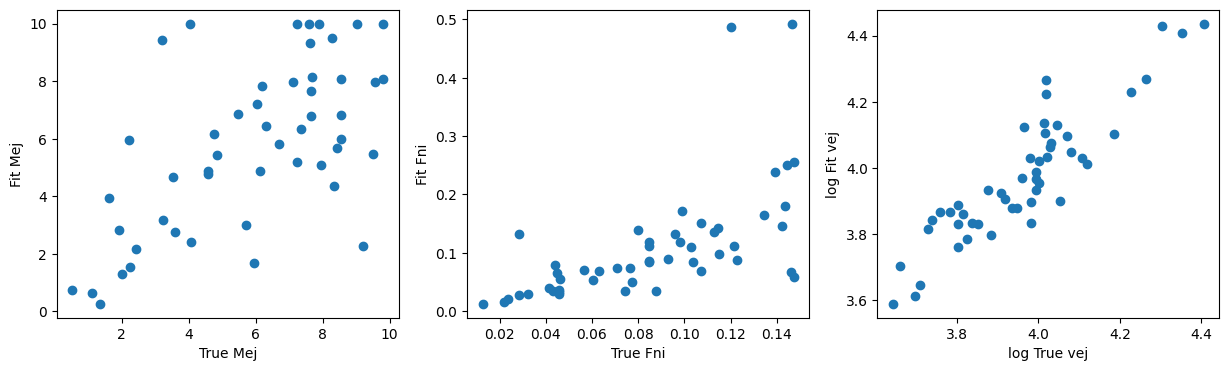

In [289]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))

ax[0].plot(fits['true_mej'], fits['fit_mej'], 'o')
ax[0].set_xlabel("True Mej")
ax[0].set_ylabel("Fit Mej")
ax[1].plot(fits['true_fni'], fits['fit_fni'], 'o')
ax[1].set_xlabel("True Fni")
ax[1].set_ylabel("Fit Fni")
ax[2].plot(np.log10(fits['true_vej']), np.log10(fits['fit_vej']), 'o')
ax[2].set_xlabel("log True vej")
ax[2].set_ylabel("log Fit vej")

(array([2.07478633e-02, 9.22457832e-02, 2.10547751e-01, 3.52009032e-01,
        5.21609113e-01, 6.79261557e-01, 8.63220725e-01, 9.88068057e-01,
        1.16797161e+00, 1.27742637e+00, 1.45128564e+00, 1.52107675e+00,
        1.68399054e+00, 1.71884695e+00, 1.79833084e+00, 1.74175572e+00,
        1.72060073e+00, 1.56861676e+00, 1.46899570e+00, 1.25273250e+00,
        1.03697038e+00, 8.45980425e-01, 6.47646511e-01, 5.08346139e-01,
        3.42707726e-01, 2.23074763e-01, 1.20165361e-01, 6.61269636e-02,
        3.47781166e-02, 2.14681665e-02, 1.23547654e-02, 1.02408322e-02,
        6.81156267e-03, 4.44708919e-03, 3.44492825e-03, 2.52106113e-03,
        1.72246412e-03, 1.19006612e-03, 8.45573297e-04, 7.20303179e-04]),
 array([0.011   , 0.049475, 0.08795 , 0.126425, 0.1649  , 0.203375,
        0.24185 , 0.280325, 0.3188  , 0.357275, 0.39575 , 0.434225,
        0.4727  , 0.511175, 0.54965 , 0.588125, 0.6266  , 0.665075,
        0.70355 , 0.742025, 0.7805  , 0.818975, 0.85745 , 0.895925,
      

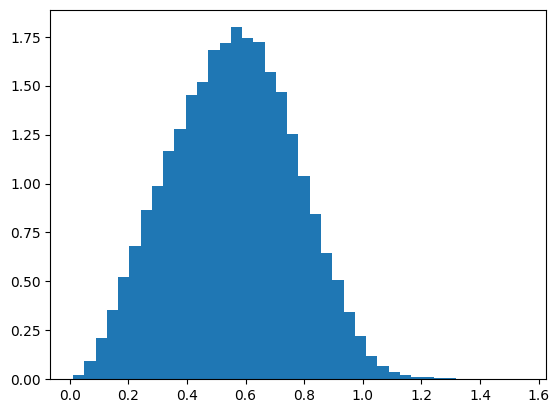

In [290]:
plt.hist(ia_df['true_z'].to_numpy(), bins=40, density=True, label="x1")


In [291]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [292]:
get_x0(np.min(ia_df['salt2_mb'].to_numpy())), get_x0(np.max(ia_df['salt2_mb'].to_numpy()))

(0.047363086913163675, 7.842959998847406e-07)

In [293]:
np.min(ia_df['salt2_color'].to_numpy()), np.max(ia_df['salt2_color'].to_numpy())

(-0.2673, 0.3732)

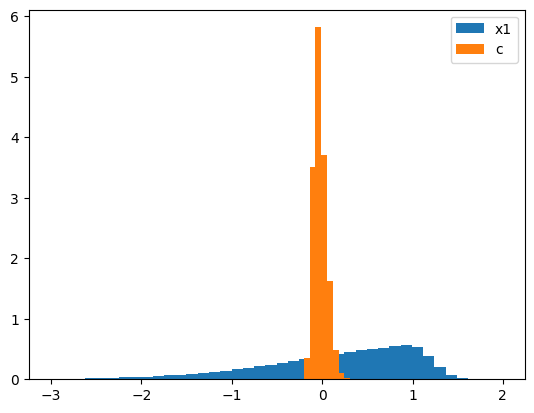

In [294]:
plt.hist(ia_df['salt2_x1'].to_numpy(), bins=40, density=True, label="x1")
plt.hist(ia_df['salt2_color'].to_numpy(), density=True, label="c")
plt.legend()

In [295]:
def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    this_ia_model = sncosmo.Model(source='salt2')

    lcs = sncosmo.realize_lcs(obs, ia_model, [params])

    return lcs

In [296]:
def fit_ia(true_z, lcs):

    this_ia_model = sncosmo.Model(source='salt2')
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-0.3, 0.4)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [297]:
light_curve = simulate_ia(0.624, 20, get_x0(23.7568), -0.3504, 0.0744)

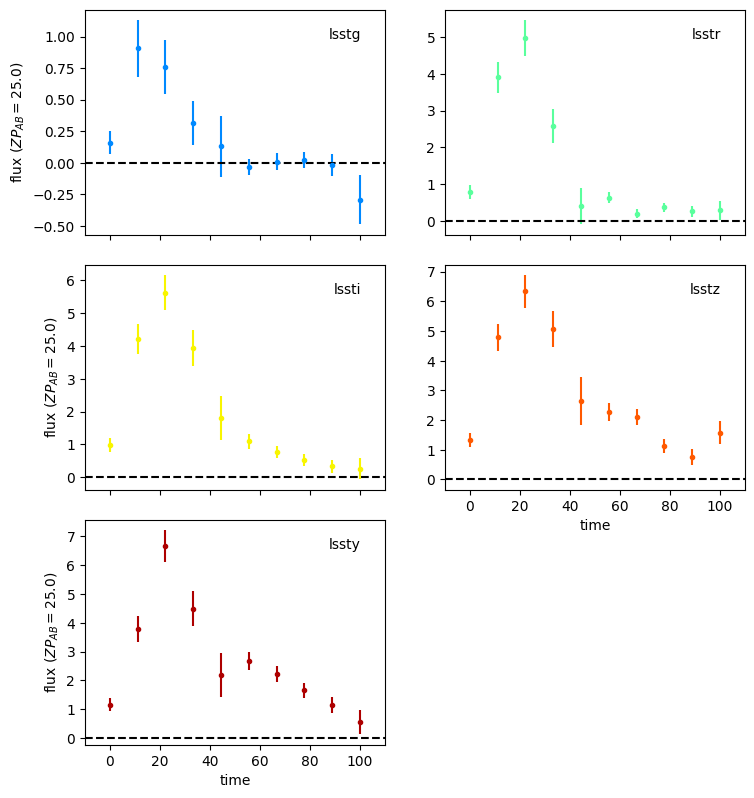

In [298]:
sncosmo.plot_lc(light_curve[0]);

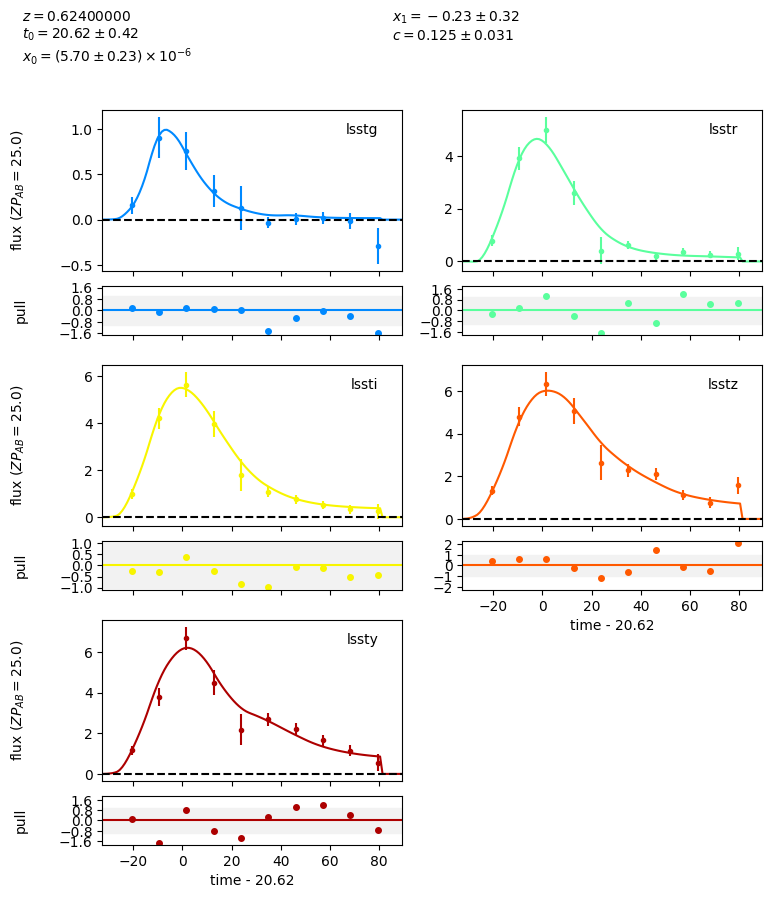

In [299]:
ia_result, ia_fitted_model = fit_ia(0.624,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


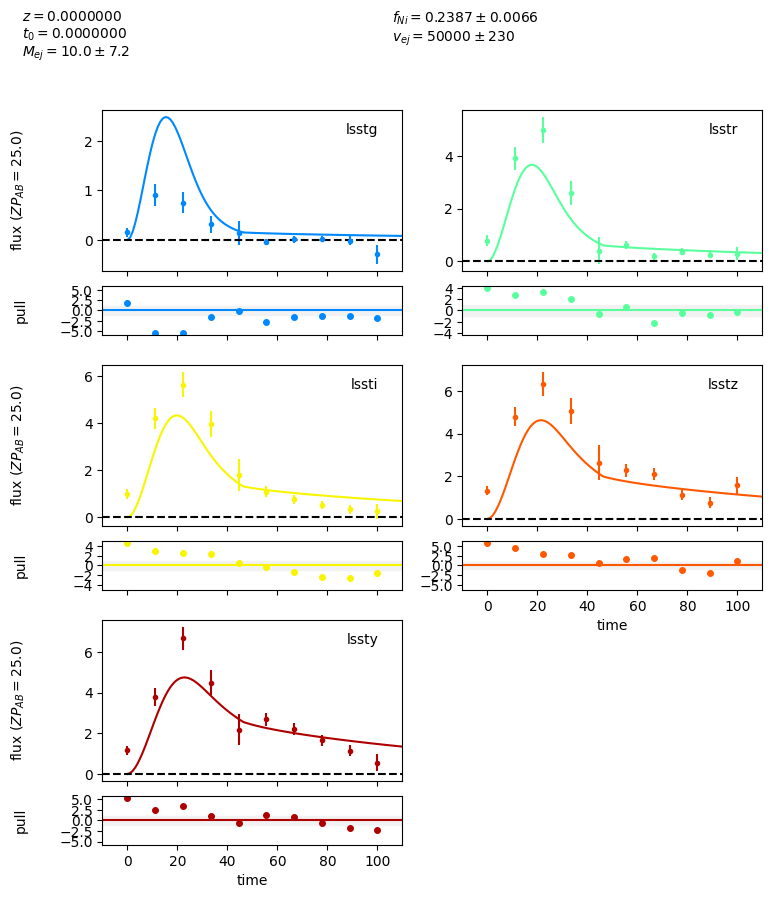

In [300]:
ibc_result, ibc_fitted_model = fit_ibc(0.624,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

In [301]:
num_to_fit = 100

fits = {'true_z': [], 'true_t0': [], 'true_x0': [], 'true_x1':[], 'true_c':[], 'fit_t0':[], 'fit_x0':[], 'fit_x1':[], 'fit_c':[]}

t0 = 20

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    
    try:
        lcs = simulate_ia(true_z, t0, x0, x1, c)

        result, model = fit_ia(true_z, lcs)
        
        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_t0'].append(t0)
        fits['true_x0'].append(x0)
        fits['true_x1'].append(x1)
        fits['true_c'].append(c)
        fits['fit_t0'].append(result_dict['t0'])
        fits['fit_x0'].append(result_dict['x0'])
        fits['fit_x1'].append(result_dict['x1'])
        fits['fit_c'].append(result_dict['c'])
    except:
        print(true_z)
        print("Did not work")

    if len(fits['fit_x0']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

0.942
Did not work
1.146
Did not work
0.988
Did not work
1.021
Did not work
1.231
Did not work
1.044
Did not work
1.26
Did not work
1.107
Did not work
1.074
Did not work
1.038
Did not work
1.224
Did not work
0.985
Did not work
0.996
Did not work
1.108
Did not work
1.105
Did not work
1.082
Did not work
1.104
Did not work
1.004
Did not work
1.01
Did not work
1.093
Did not work
1.113
Did not work
1.097
Did not work
1.051
Did not work
1.032
Did not work
1.21
Did not work
1.356
Did not work
0.982
Did not work
1.194
Did not work
1.107
Did not work
0.968
Did not work
1.285
Did not work
1.151
Did not work
1.408
Did not work
1.206
Did not work
1.171
Did not work
1.139
Did not work
1.038
Did not work
1.128
Did not work
1.152
Did not work
1.171
Did not work
1.05
Did not work
1.153
Did not work
0.94
Did not work
0.998
Did not work
1.005
Did not work
1.28
Did not work
1.11
Did not work
1.107
Did not work
1.034
Did not work
1.265
Did not work
1.329
Did not work
1.342
Did not work
0.07187031984329223

Text(0, 0.5, 'log Fit x0')

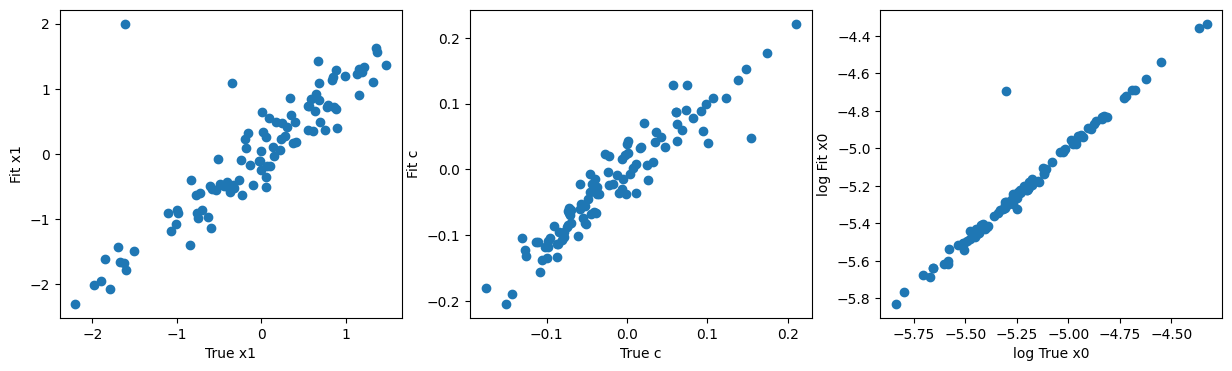

In [302]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))

ax[0].plot(fits['true_x1'], fits['fit_x1'], 'o')
ax[0].set_xlabel("True x1")
ax[0].set_ylabel("Fit x1")
ax[1].plot(fits['true_c'], fits['fit_c'], 'o')
ax[1].set_xlabel("True c")
ax[1].set_ylabel("Fit c")
ax[2].plot(np.log10(fits['true_x0']), np.log10(fits['fit_x0']), 'o')
ax[2].set_xlabel("log True x0")
ax[2].set_ylabel("log Fit x0")